In [4]:
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.matlib
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import math
#from pyleoclim.utils import tsutils

In [5]:
def distance_neighbors(signal):
    nn = NearestNeighbors(4) # 4 nearest neighbors
    nbrs =nn.fit(signal.reshape(-1,1))
    distances, indices = nbrs.kneighbors(signal.reshape(-1,1))
    distances = sorted(distances[:,-1],reverse=True)
    return distances
    


References : https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve

In [6]:
def find_knee(distances):
    nPoints = len(distances)
    allCoord = np.vstack((range(nPoints), distances)).T
    np.array([range(nPoints), distances])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return distances[idxOfBestPoint]

In [7]:
def detect_outliers(ts, ys,plot=True,auto=True):

        try:
            minpts = math.log(len(ys))
            distances = distance_neighbors(ys)
            index = [i for i in range(len(distances))]
            
            flag =all(v < 0.001 for v in distances)


            knee_point = find_knee(distances)
            mark = distances.index(knee_point)

            fig,ax = plt.subplots(figsize=[10,4])

            ax.plot(index,distances)
            ax.annotate("knee={}".format(knee_point),(mark,knee_point),arrowprops=dict(facecolor='black', shrink=0.05))
            plt.show()
            if auto ==True:
                if flag==True:
                    knee_point = 0.01
                db = DBSCAN(eps=knee_point,min_samples=minpts)
                clusters = db.fit(ys.reshape(-1,1))
                cluster_labels = clusters.labels_
                outliers = np.where(cluster_labels ==-1)
            if auto == False:
                eps = float(input('Enter the value for eps'))
                db = DBSCAN(eps=eps,min_samples=minpts)
                clusters = db.fit(ys.reshape(-1,1))
                cluster_labels = clusters.labels_
                outliers = np.where(cluster_labels ==-1)
            if plot == True:

                fig,ax = plt.subplots(figsize=[10,4]) 
                ax.plot(ts,ys,color='green')
                ax.scatter(ts[outliers],ys[outliers],marker='x',color='red')
                plt.show()
            return outliers

        except ValueError:
            print('Please Enter a valid numerical value')

    
    

In [8]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))

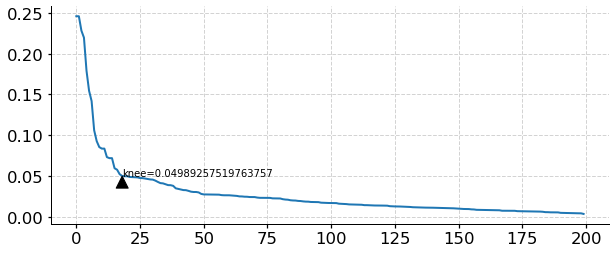

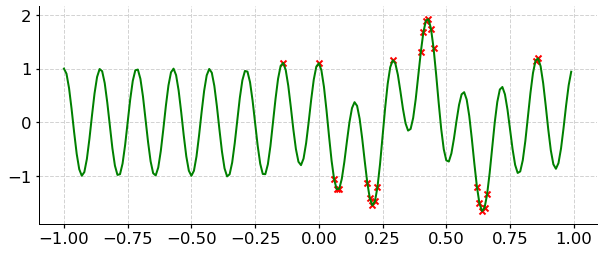

(array([ 86, 100, 106, 107, 108, 119, 120, 121, 122, 123, 129, 140, 141,
        142, 143, 144, 145, 162, 163, 164, 165, 166, 185, 186]),)

In [9]:
detect_outliers(t,sig)

# Mixed signal with outliers

In [10]:
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

#Add outliers

outliers_start = np.mean(signal)+5*np.std(signal)
outliers_end = np.mean(signal)+6*np.std(signal)
outlier_values = np.arange(outliers_start,outliers_end,0.1)
index = np.random.randint(0,len(signal),6)
print(index)
signal_out = signal
for i,ind in enumerate(index):
    signal_out[ind] = outlier_values[i]


[1711  142 1349 1307  845  165]


In [11]:
signal = pd.Series(signal_out)

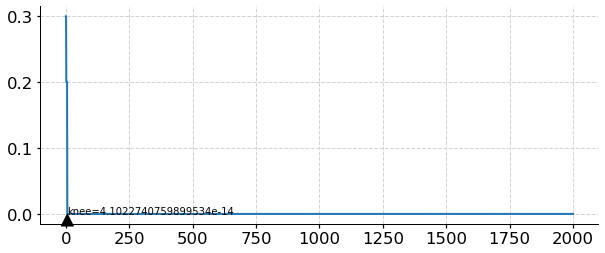

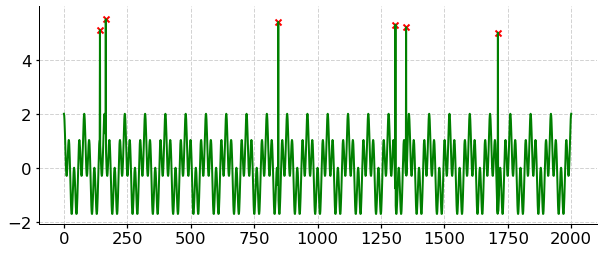

(array([ 142,  165,  845, 1307, 1349, 1711]),)

In [12]:
detect_outliers(signal.index,signal.values)

Mixed Frequency Signal

In [16]:
freqs=[1/100,1/10,1/50]
time=np.arange(2000)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

In [17]:
series_mixed = pd.Series(signal)

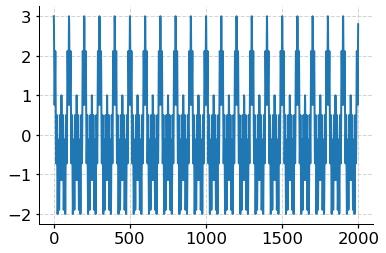

In [18]:
plt.plot(series_mixed)

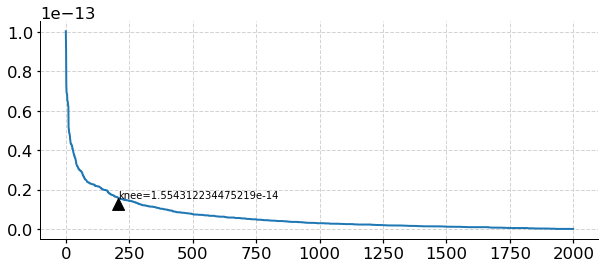

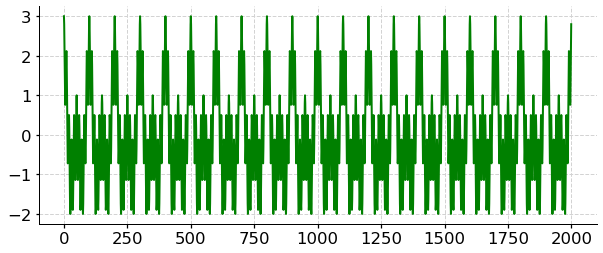

(array([], dtype=int64),)

In [19]:
detect_outliers(series_mixed.index,series_mixed.values)

In [20]:
def colored_noise(alpha, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries
    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

In [21]:
time = np.arange(2001)
signal = colored_noise(1, time, seed=2333)

colored_noise_signal = pd.Series(signal, index=time)

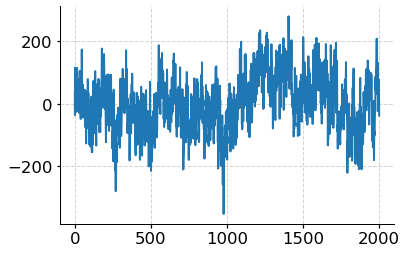

In [22]:
plt.plot(colored_noise_signal)

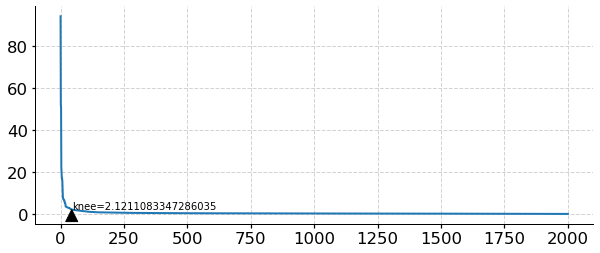

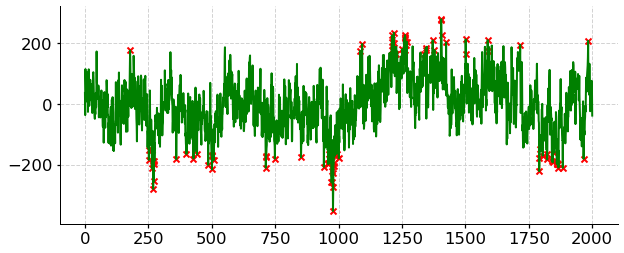

(array([ 178,  252,  253,  264,  266,  269,  270,  271,  272,  274,  360,
         400,  428,  442,  486,  499,  500,  501,  507,  713,  714,  715,
         749,  852,  942,  959,  960,  962,  964,  965,  971,  972,  973,
         974,  975,  977,  978,  979,  980,  981,  985,  990,  991,  992,
        1001, 1085, 1093, 1209, 1210, 1211, 1213, 1217, 1218, 1223, 1228,
        1252, 1260, 1261, 1262, 1263, 1264, 1269, 1338, 1343, 1344, 1371,
        1378, 1404, 1405, 1406, 1424, 1501, 1502, 1588, 1589, 1716, 1791,
        1792, 1793, 1805, 1822, 1823, 1841, 1844, 1850, 1860, 1861, 1863,
        1865, 1867, 1884, 1966, 1984]),)

In [23]:
detect_outliers(colored_noise_signal.index,colored_noise_signal.values)

In [24]:
def generate_signal(kind):
    series = pd.Series()
    if (kind == 'Constant'):
        time = np.arange(2001)
        f = 1/50
        signal = np.cos(2*np.pi*f*time)

        series = pd.Series(signal, index=time)
    
    elif kind =='Two_Constant':
        time1 = np.arange(1000)
        f1 = 1/50
        signal1 = np.cos(2*np.pi*f1*time1)

        time2 = np.arange(1000, 2001)
        f2 = 1/100
        signal2 = np.cos(2*np.pi*f2*time2)

        signal = np.concatenate([signal1, signal2])
        time = np.concatenate([time1, time2])

        series = pd.Series(signal, index=time)
    
    elif kind == 'Two_Close':
        time1 = np.arange(1000)
        f1 = 1/50
        signal1 = np.cos(2*np.pi*f1*time1)

        time2 = np.arange(1000, 2001)
        f2 = 1/55
        signal2 = np.cos(2*np.pi*f2*time2)

        signal = np.concatenate([signal1, signal2])
        time = np.concatenate([time1, time2])

        series = pd.Series(signal, index=time)
        return series
    
    elif kind == 'Variant':
        freqs=[1/20,1/80,1/200]
        time=np.arange(2000)
        signals=[]
        for freq in freqs:
            signals.append(np.cos(2*np.pi*freq*time))
        signal=sum(signals)
        series=pd.Series(signal,index=time)


        
        
    return series

In [25]:
def add_white_noise (signal,snr):
    np.random.seed(2333)
    time = signal.index
    sig_var = np.var(signal)
    noise_var = sig_var/snr
    white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
    signal_noise = signal + white_noise
    series = pd.Series(signal_noise, index=time)
    return series

In [26]:
constant_signal = generate_signal('Constant')

/home/pratheek/anaconda3/envs/pyleoclim/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [27]:
signal_with_noise = add_white_noise(constant_signal,0.6)

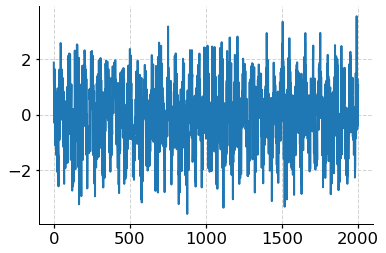

In [28]:
plt.plot(signal_with_noise)

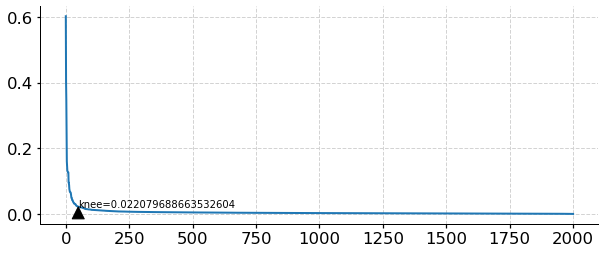

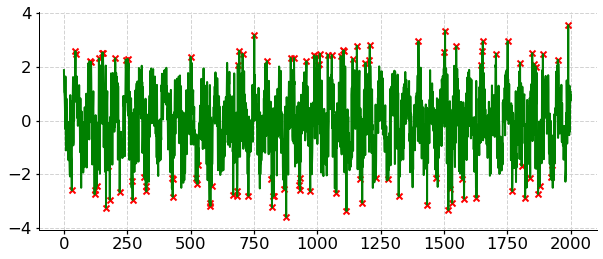

(array([  31,   45,   46,  101,  107,  121,  124,  129,  138,  152,  154,
         166,  175,  181,  202,  220,  244,  251,  270,  271,  317,  323,
         325,  427,  429,  430,  500,  522,  527,  531,  575,  578,  583,
         668,  683,  684,  686,  692,  705,  728,  751,  801,  819,  821,
         825,  827,  870,  877,  895,  908,  928,  930,  932,  957,  972,
         988,  998, 1002, 1007, 1010, 1041, 1057, 1075, 1092, 1103, 1105,
        1115, 1139, 1156, 1168, 1177, 1190, 1205, 1207, 1231, 1280, 1321,
        1399, 1433, 1470, 1501, 1504, 1517, 1522, 1532, 1548, 1571, 1579,
        1628, 1644, 1651, 1653, 1705, 1751, 1769, 1800, 1806, 1820, 1840,
        1848, 1856, 1863, 1871, 1878, 1890, 1921, 1926, 1949, 1990]),)

In [29]:
detect_outliers(signal_with_noise.index,signal_with_noise.values)

In [30]:
signal_with_noise = add_white_noise(constant_signal,1)

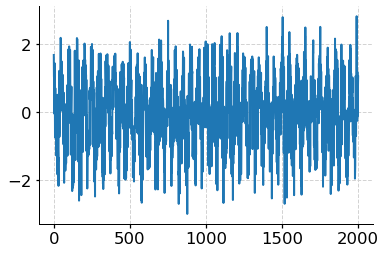

In [31]:
plt.plot(signal_with_noise)

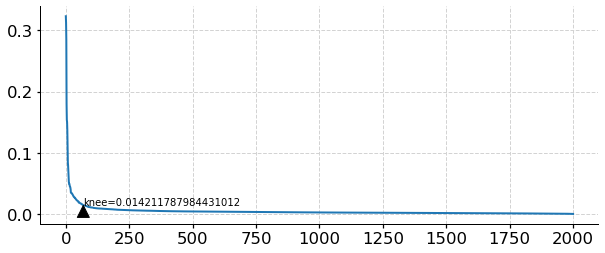

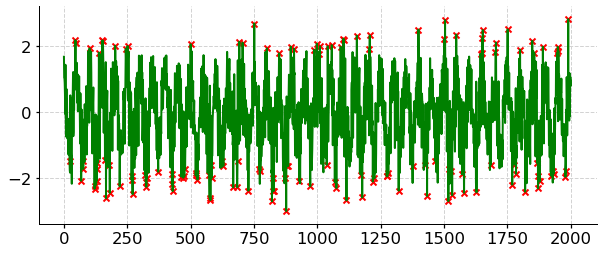

(array([  22,   45,   46,   68,   76,   77,  101,  121,  124,  129,  130,
         132,  138,  152,  154,  162,  166,  176,  181,  202,  220,  244,
         251,  267,  270,  271,  321,  323,  325,  327,  372,  426,  427,
         429,  463,  471,  475,  478,  500,  520,  522,  527,  574,  575,
         578,  580,  583,  624,  629,  668,  684,  685,  692,  705,  728,
         751,  771,  775,  801,  821,  824,  825,  827,  849,  874,  877,
         882,  885,  895,  908,  928,  972,  988,  998, 1007, 1010, 1037,
        1041, 1057, 1069, 1075, 1092, 1103, 1105, 1115, 1156, 1171, 1177,
        1205, 1207, 1219, 1225, 1274, 1276, 1280, 1321, 1378, 1399, 1425,
        1433, 1465, 1501, 1504, 1517, 1521, 1528, 1532, 1548, 1571, 1579,
        1628, 1644, 1650, 1651, 1653, 1685, 1703, 1705, 1751, 1769, 1777,
        1784, 1800, 1820, 1848, 1856, 1868, 1871, 1872, 1878, 1890, 1923,
        1928, 1932, 1947, 1949, 1951, 1979, 1980, 1990]),)

In [32]:
detect_outliers(signal_with_noise.index,signal_with_noise.values)

In [33]:
two_constant = generate_signal('Two_Constant')

/home/pratheek/anaconda3/envs/pyleoclim/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [34]:
two_constant_with_noise = add_white_noise(two_constant,0.4)

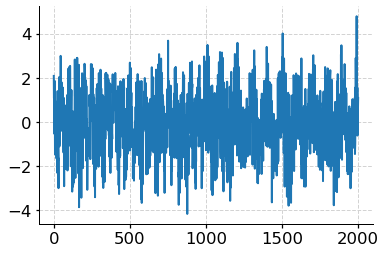

In [35]:
plt.plot(two_constant_with_noise)

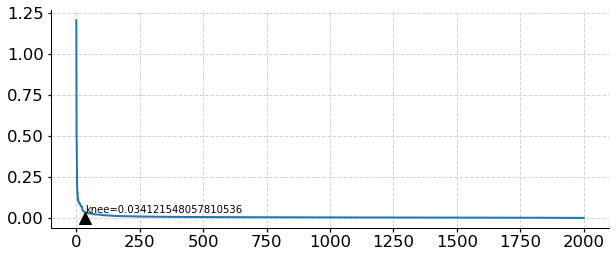

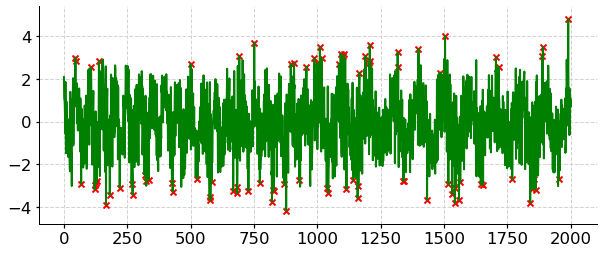

(array([  45,   46,   68,  107,  121,  124,  127,  129,  138,  166,  181,
         220,  267,  271,  321,  323,  335,  426,  429,  500,  527,  575,
         578,  583,  668,  683,  684,  692,  728,  751,  773,  821,  825,
         827,  870,  877,  895,  908,  928,  957,  988,  998, 1007, 1010,
        1017, 1037, 1043, 1085, 1092, 1103, 1105, 1115, 1141, 1159, 1162,
        1166, 1190, 1205, 1207, 1209, 1317, 1319, 1339, 1342, 1399, 1433,
        1486, 1504, 1517, 1532, 1542, 1543, 1559, 1564, 1645, 1654, 1705,
        1715, 1769, 1840, 1849, 1854, 1861, 1887, 1890, 1953, 1990]),)

In [36]:
detect_outliers(two_constant_with_noise.index,two_constant_with_noise.values)

In [37]:
import pyleoclim as pyleo

[ 683 1053  662 1384 1842  694]


Text(0, 0.5, 'Value')

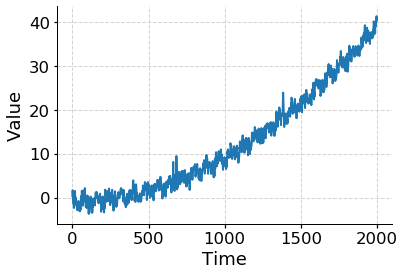

In [42]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

#Add outliers

outliers_start = np.mean(signal)+5*np.std(signal)
outliers_end = np.mean(signal)+6*np.std(signal)
outlier_values = np.arange(outliers_start,outliers_end,0.1)
index = np.random.randint(0,len(signal),6)
print(index)
signal_out = signal
for i,ind in enumerate(index):
    signal_out[ind] = outlier_values[i]

# Add a non-linear trend
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
#signal_trend = signal_out + nonlinear_trend

#Add white noise
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise

#Remove data points
del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal_noise, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')

In [43]:
ts = pyleo.Series(time=time_unevenly,value=signal_unevenly)


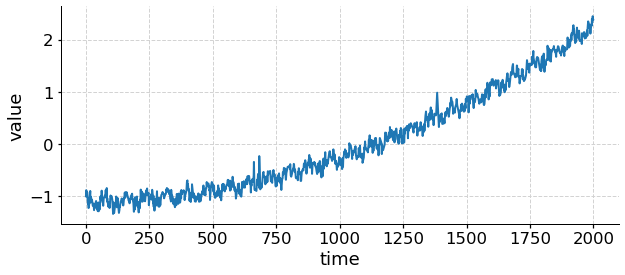

In [44]:
ts_std = ts.standardize()
fig,ax = ts_std.plot()

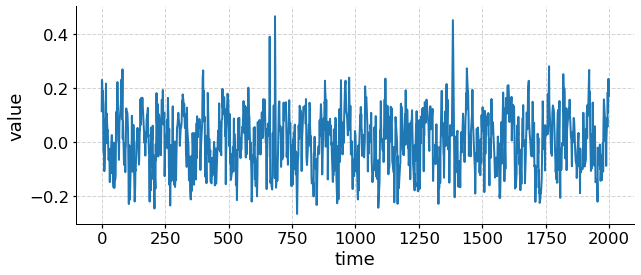

In [45]:
ts_detrended = ts_std.detrend(method='emd')
fig,ax = ts_detrended.plot()

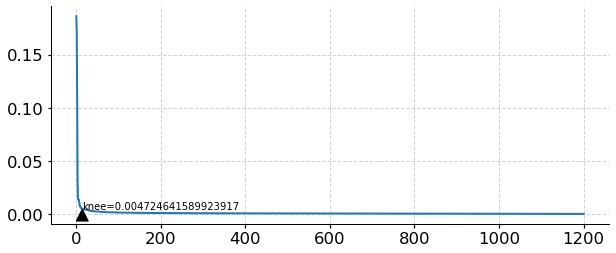

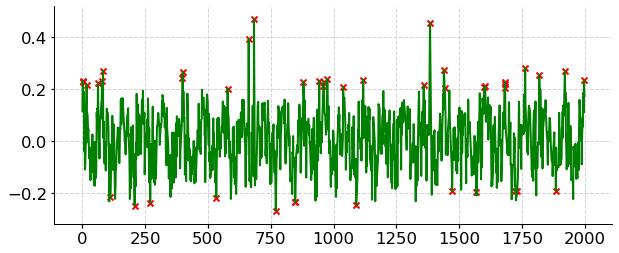

(array([   1,    2,   15,   47,   54,   56,   74,  136,  174,  242,  243,
         323,  348,  401,  415,  466,  511,  512,  533,  577,  584,  585,
         592,  631,  661,  678,  827,  842,  873,  874,  891,  947,  964,
         965, 1018, 1019, 1020, 1044, 1049, 1067, 1099, 1134, 1151, 1198]),)

In [46]:
detect_outliers(ts_detrended.time,ts_detrended.value)

# Noisy signal with outliers

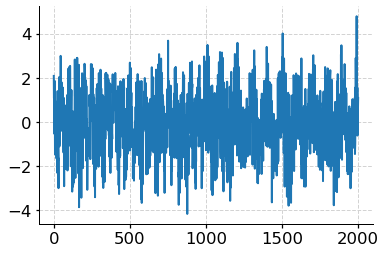

In [280]:
plt.plot(two_constant_with_noise)

In [281]:
outliers_start = np.mean(signal)+5*np.std(two_constant_with_noise)
outliers_end = np.mean(signal)+7*np.std(two_constant_with_noise)
outlier_values = np.arange(outliers_start,outliers_end,0.01)
index = np.random.randint(0,len(signal),15)
print(index)
signal_out = two_constant_with_noise.copy()
for i,ind in enumerate(index):
    signal_out[ind] = outlier_values[i]


[1046 1457 1921  478 1635 1923   42   35  666 1875 1607  734 1416  289
  408]


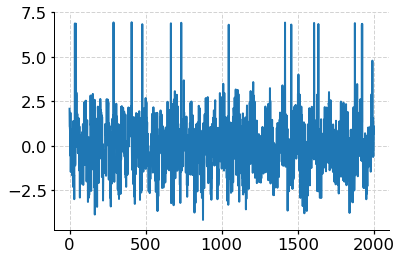

In [312]:
plt.plot(signal_out)

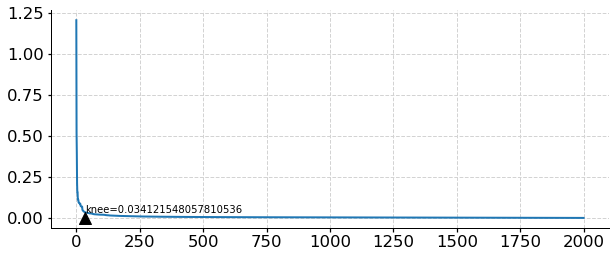

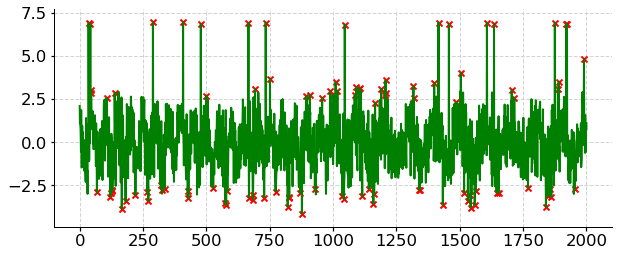

(array([  35,   42,   45,   46,   68,  107,  121,  124,  127,  129,  138,
         166,  181,  220,  267,  271,  289,  321,  323,  335,  408,  426,
         429,  478,  500,  527,  575,  578,  583,  666,  668,  683,  684,
         692,  728,  734,  751,  773,  821,  825,  827,  870,  877,  895,
         908,  928,  957,  988,  998, 1007, 1010, 1017, 1037, 1043, 1046,
        1085, 1092, 1103, 1105, 1115, 1141, 1159, 1162, 1166, 1190, 1205,
        1207, 1209, 1317, 1319, 1339, 1342, 1399, 1416, 1433, 1457, 1486,
        1504, 1517, 1532, 1542, 1543, 1559, 1564, 1607, 1635, 1645, 1654,
        1705, 1715, 1769, 1840, 1849, 1854, 1861, 1875, 1887, 1890, 1921,
        1923, 1953, 1990]),)

In [313]:
detect_outliers(signal_out.index,signal_out.values)

In [310]:
time1 = np.arange(1000)
f1 = 1/100
y1 = np.cos(2*np.pi*time1*f1)

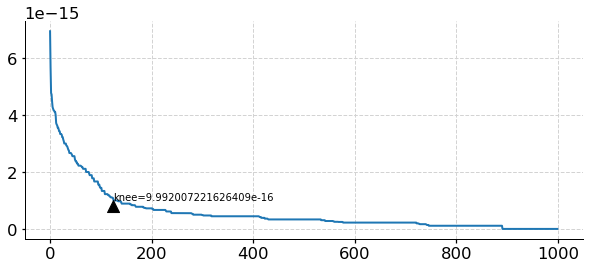

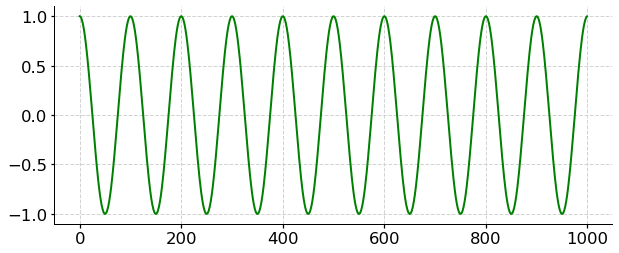

(array([], dtype=int64),)

In [311]:
detect_outliers(time1,y1,auto=True)